In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional
from keras.utils import plot_model


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix

In [58]:
#loading the wednesday dataset which contains LDOS data

df = pd.read_csv('Final_data.csv')
df.drop(1676519)   #because it contains a row having differnt label

,Time,Source,Destination,Protocol,Length,src_port,dst_port,Flow_Duration,Total_Packets,Total_Bytes,...,Flow_Count_Per_Source,Packet_Loss_Rate,Round_Trip_Time,Connection_Patterns,Traffic_Patterns,Label,source_ip_entropy,source_port_entropy,dest_ip_entropy,dest_port_entropy
0,124.583118,10.0.0.5,10.0.0.11,0,80,55842,5001,0.000000,1,80,...,4,NaN,0.000000e+00,107397,8754067693894,normal,3.055542,3.148007,1.189296,1.576999
1,124.583136,10.0.0.11,10.0.0.5,0,60,5001,55842,0.000000,1,60,...,81,NaN,1.800000e-08,659398,13035940106280,normal,3.055542,3.148007,1.189296,1.576999
2,124.631696,10.0.0.5,10.0.0.11,1,1518,60386,5001,0.062287,53697,81512046,...,4,862090.002729,4.403531e-02,107397,8754067693894,normal,3.055542,3.148007,1.189296,1.576999
3,124.631775,10.0.0.5,10.0.0.11,1,1518,60386,5001,0.062287,53697,81512046,...,4,862090.002729,4.403531e-02,107397,8754067693894,normal,3.055542,3.148007,1.189296,1.576999
4,124.631783,10.0.0.5,10.0.0.11,1,1518,60386,5001,0.062287,53697,81512046,...,4,862090.002729,4.403531e-02,107397,8754067693894,normal,3.055542,3.148007,1.189296,1.576999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2171847,61447.545126,10.0.0.11,10.0.0.2,0,1520,80,40152,0.001052,6,2033,...,81,5703.422053,9.252330e-04,659398,13035940106280,normal,3.055542,3.148007,1.189296,1.576999
2171848,61447.580148,10.0.0.2,10.0.0.11,0,72,40152,80,0.000163,6,456,...,31,36809.815951,1.129421e-03,337230,59829408532080,attack,3.055542,3.148007,1.189296,1.576999
2171849,61447.580227,10.0.0.2,10.0.0.11,0,72,40152,80,0.000163,6,456,...,31,36809.815951,1.129421e-03,337230,59829408532080,attack,3.055542,3.148007,1.189296,1.576999
2171850,61447.622449,10.0.0.2,10.0.0.11,0,72,40152,80,0.000163,6,456,...,31,36809.815951,1.129421e-03,337230,59829408532080,attack,3.055542,3.148007,1.189296,1.576999


In [59]:
#data preprocessing

#replacing NAN values with 0
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

# Separating the features and label
X = df.drop('Label', axis=1)
Y = df['Label']

non_float_cols = X.select_dtypes(exclude='float64').columns

# Convert non-float columns to float, handling potential errors
for col in non_float_cols:
    try:
        X[col] = pd.to_numeric(df[col], errors='coerce')
        # print(col)
    except ValueError:
        print(f"Error converting column '{col}' to float. Check for non-numeric values.")

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)

# # Standardize the features
#i dont want to do this because it contains things like ip add ports and all
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# pca for dimensionality reduction
# pca = PCA(n_components=10)
# X_pca = pca.fit_transform(X)

print(Y.unique()) #['attack' 'normal']

# # for i in range(len(Y)):
# #   if Y[i]==0:
# #     print(i)

#replacing the labels with 0 for non attcak and 1 for LDOS

Y.replace('normal', 0, inplace=True)
Y.replace('attack', 1, inplace=True)

print(Y.unique()) # 0 1



['normal' 'attack']
[0 1]


<ipython-input-59-8567da45011d>:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y.replace('attack', 1, inplace=True)


In [60]:

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Further split X_train into 4 parts: 1 for base model and 3 for federated clients and 1 test set for the base model after federated update
#  split the training data into 2 parts
trainX1,trainX2,trainY1,trainY2 = train_test_split(X_train, y_train, test_size=0.5, random_state=42)
#split each of the 2 in 2 to get 4 parts
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(trainX1, trainY1, test_size=0.5, random_state=42)
X_train_3, X_train_4, y_train_3, y_train_4 = train_test_split(trainX2, trainY2, test_size=0.5, random_state=42)


X_train_list=[X_train_1,X_train_2,X_train_3,X_train_4]
y_train_list=[y_train_1,y_train_2,y_train_3,y_train_4]

X_train_reshaped = [None]*4

# print(X_train)
# print(y_train)

#let us reshape without consodering the timestamp

for i in range(4):
  X_train_reshaped[i]=X_train_list[i].to_numpy().reshape((X_train_list[i].shape[0], 1, X_train_list[i].shape[1])) #row timestamp Columns

X_test_reshaped = X_test.to_numpy().reshape((X_test.shape[0], 1, X_test.shape[1]))#row timestamp Columns



# Save to CSV files so we could use it later
# df_X1_train = pd.DataFrame(X_train_1)
# df_y1_train = pd.DataFrame(y_train_1)
# df_X1_train.to_csv('X_train1.csv', index=False)
# df_y1_train.to_csv('y_train1.csv', index=False)


# df_X2_train = pd.DataFrame(X_train_2)
# df_y2_train = pd.DataFrame(y_train_2)
# df_X2_train.to_csv('X_train2.csv', index=False)
# df_y2_train.to_csv('y_train2.csv', index=False)

# df_X3_train = pd.DataFrame(X_train_3)
# df_y3_train = pd.DataFrame(y_train_3)
# df_X3_train.to_csv('X_train3.csv', index=False)
# df_y3_train.to_csv('y_train3.csv', index=False)

# df_X4_train = pd.DataFrame(X_train_4)
# df_y4_train = pd.DataFrame(y_train_4)
# df_X4_train.to_csv('X_train4.csv', index=False)
# df_y4_train.to_csv('y_train4.csv', index=False)

# df_X_test = pd.DataFrame(X_test)
# df_y_test = pd.DataFrame(y_test)
# df_X_test.to_csv('X_test.csv', index=False)
# df_y_test.to_csv('y_test.csv', index=False)


In [61]:
def create_sequential():
  model = Sequential()
  model.add(Bidirectional(LSTM(64, activation='tanh', kernel_regularizer='l2')))
  model.add(Dense(128, activation = 'relu', kernel_regularizer='l2'))
  model.add(Dense(1, activation = 'sigmoid', kernel_regularizer='l2'))
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  return model

def print_accuracy_loss(model,X_test,y_test):
  loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
  print("Accuracy and loss is ",accuracy, loss)

def print_confusion_matrix(model,X_test,y_test):
  y_pred = model.predict(X_test)
  y_pred_binary = (y_pred > 0.5).astype(int)
  cm = confusion_matrix(y_test, y_pred_binary)
  print("Confusion Matrix:")
  print(cm)

def plot_confusion_matrix(model,X_test, y_test, labels=['Attack', 'Normal']):
  y_pred = model.predict(X_test)
  y_pred_classes = np.argmax(y_pred, axis=1)
  cm = confusion_matrix(y_test, y_pred_classes)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot()
  plt.show()

In [68]:
#training the federated architecture

weightstemp=None;

remote_models_count=3

weights_remote_models=[]

remote_models=[None]*remote_models_count

# for i in range(remote_models_count):
#   remote_models[i] = create_sequential()

print(X_train_reshaped[0].shape)

for i in range(1):
  # base_model = create_sequential()
  # history_base = base_model.fit(X_train_reshaped[0] , y_train_list[0], epochs = 10,validation_split=0.2, verbose = 1)
  # print_accuracy_loss(base_model,X_test_reshaped,y_test)
  # base_model.save('base_model.h5')

  for j in range(remote_models_count):
    remote_models[j]=load_model('base_model.h5')
    adam = tf.keras.optimizers.Adam()  # Define your optimizer
    remote_models[j].compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])  # Recompile
    remote_models[j].fit(X_train_reshaped[j+1], y_train_list[j+1], epochs = 10,validation_split=0.2, verbose = 1)
    print_accuracy_loss(remote_models[j],X_test_reshaped,y_test)
    remote_models[j].save('remote_model'+str(j+1)+'.h5')

    #saving the weights of the model to our weights list
    weights_remote_models.append(remote_models[j].get_weights())


(434370, 1, 27)
Epoch 1/10
10860/10860 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - accuracy: 0.6981 - loss: 0.6125 - val_accuracy: 0.6971 - val_loss: 0.6133
Epoch 2/10
10860/10860 ━━━━━━━━━━━━━━━━━━━━ 71s 7ms/step - accuracy: 0.6974 - loss: 0.6131 - val_accuracy: 0.6971 - val_loss: 0.6133
Epoch 3/10
10860/10860 ━━━━━━━━━━━━━━━━━━━━ 86s 7ms/step - accuracy: 0.6971 - loss: 0.6133 - val_accuracy: 0.6971 - val_loss: 0.6133
Epoch 4/10
10860/10860 ━━━━━━━━━━━━━━━━━━━━ 75s 7ms/step - accuracy: 0.6976 - loss: 0.6129 - val_accuracy: 0.6971 - val_loss: 0.6133
Epoch 5/10
10860/10860 ━━━━━━━━━━━━━━━━━━━━ 86s 7ms/step - accuracy: 0.6980 - loss: 0.6126 - val_accuracy: 0.6971 - val_loss: 0.6134
Epoch 6/10
10860/10860 ━━━━━━━━━━━━━━━━━━━━ 78s 7ms/step - accuracy: 0.6984 - loss: 0.6122 - val_accuracy: 0.6971 - val_loss: 0.6133
Epoch 7/10
10860/10860 ━━━━━━━━━━━━━━━━━━━━ 70s 6ms/step - accuracy: 0.6973 - loss: 0.6131 - val_accuracy: 0.6971 - val_loss: 0.6133
Epoch 8/10
10860/10860 ━━━━━━━━━━━━━━━━━━━━ 69s 6ms/s

Accuracy and loss is  0.6964138746261597 0.613894522190094
Epoch 1/10
10860/10860 ━━━━━━━━━━━━━━━━━━━━ 74s 7ms/step - accuracy: 0.6947 - loss: 0.6153 - val_accuracy: 0.6975 - val_loss: 0.6130
Epoch 2/10
10860/10860 ━━━━━━━━━━━━━━━━━━━━ 86s 7ms/step - accuracy: 0.6955 - loss: 0.6147 - val_accuracy: 0.6975 - val_loss: 0.6130
Epoch 3/10
10860/10860 ━━━━━━━━━━━━━━━━━━━━ 73s 7ms/step - accuracy: 0.6955 - loss: 0.6146 - val_accuracy: 0.6975 - val_loss: 0.6131
Epoch 4/10
10860/10860 ━━━━━━━━━━━━━━━━━━━━ 78s 6ms/step - accuracy: 0.6956 - loss: 0.6145 - val_accuracy: 0.6975 - val_loss: 0.6130
Epoch 5/10
10860/10860 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - accuracy: 0.6966 - loss: 0.6137 - val_accuracy: 0.6975 - val_loss: 0.6130
Epoch 6/10
10860/10860 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.6948 - loss: 0.6152 - val_accuracy: 0.6975 - val_loss: 0.6130
Epoch 7/10
10860/10860 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - accuracy: 0.6974 - loss: 0.6131 - val_accuracy: 0.6975 - val_loss: 0.6130
Epoch 8/10

Accuracy and loss is  0.6964138746261597 0.6138776540756226
Epoch 1/10
10860/10860 ━━━━━━━━━━━━━━━━━━━━ 71s 6ms/step - accuracy: 0.6968 - loss: 0.6136 - val_accuracy: 0.6961 - val_loss: 0.6142
Epoch 2/10
10860/10860 ━━━━━━━━━━━━━━━━━━━━ 84s 6ms/step - accuracy: 0.6950 - loss: 0.6151 - val_accuracy: 0.6961 - val_loss: 0.6142
Epoch 3/10
10860/10860 ━━━━━━━━━━━━━━━━━━━━ 79s 6ms/step - accuracy: 0.6952 - loss: 0.6149 - val_accuracy: 0.6961 - val_loss: 0.6141
Epoch 4/10
10860/10860 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step - accuracy: 0.6965 - loss: 0.6139 - val_accuracy: 0.6961 - val_loss: 0.6142
Epoch 5/10
10860/10860 ━━━━━━━━━━━━━━━━━━━━ 71s 6ms/step - accuracy: 0.6954 - loss: 0.6148 - val_accuracy: 0.6961 - val_loss: 0.6141
Epoch 6/10
10860/10860 ━━━━━━━━━━━━━━━━━━━━ 77s 6ms/step - accuracy: 0.6959 - loss: 0.6143 - val_accuracy: 0.6961 - val_loss: 0.6141
Epoch 7/10
10860/10860 ━━━━━━━━━━━━━━━━━━━━ 85s 6ms/step - accuracy: 0.6948 - loss: 0.6153 - val_accuracy: 0.6961 - val_loss: 0.6141
Epoch 8/1

Accuracy and loss is  0.6964138746261597 0.6138997673988342


Accuracy and loss is  0.6964138746261597 0.6138695478439331
13575/13575 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step


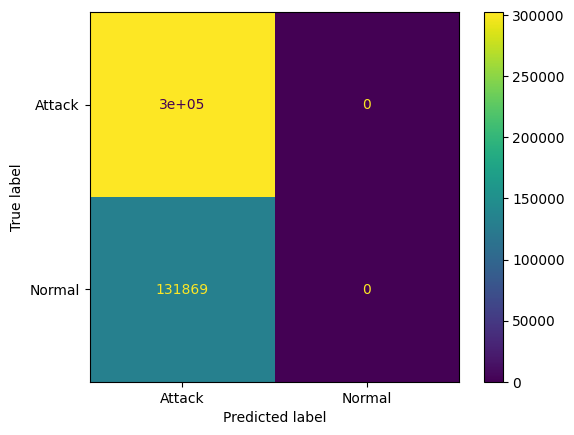

In [70]:
weightstemp=[(w1 + w2 + w3) / 3 for w1, w2, w3 in zip(weights_remote_models[0],weights_remote_models[2],weights_remote_models[2])]

base_model.set_weights(weightstemp)

print_accuracy_loss(base_model,X_test_reshaped,y_test)

plot_confusion_matrix(base_model,X_test_reshaped,y_test)
base_model.save('federated_base_model.h5')